In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

teja8y_inaturalist_path = kagglehub.dataset_download('teja8y/inaturalist')

print('Data source import complete.')


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: fgbb66579 (fgbb66579-iit-madras-foundation). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]



Epoch 1/50

Epoch 2/50

Epoch 3/50

Epoch 4/50

Epoch 5/50

Epoch 6/50

Epoch 7/50

Epoch 8/50

Epoch 9/50

Epoch 10/50

Epoch 11/50

Epoch 12/50

Epoch 13/50

Epoch 14/50

Epoch 15/50

Epoch 16/50

Epoch 17/50

Epoch 18/50

Epoch 19/50

Epoch 20/50

Epoch 21/50

Epoch 22/50

Epoch 23/50

Epoch 24/50

Epoch 25/50

Epoch 26/50

Epoch 27/50

Epoch 28/50

Epoch 29/50

Epoch 30/50

Epoch 31/50

Epoch 32/50

Epoch 33/50

Epoch 34/50

Epoch 35/50

Epoch 36/50

Epoch 37/50

Epoch 38/50

Epoch 39/50

Epoch 40/50

Epoch 41/50

Epoch 42/50

Epoch 43/50

Epoch 44/50

Epoch 45/50

Epoch 46/50

Epoch 47/50

Epoch 48/50

Epoch 49/50

Epoch 50/50

Test Accuracy: 78.10%
Accuracy plot saved to 'finetune_resnet50_accuracy.png'

=== Analysis Summary ===
Best Validation Accuracy: 78.55%
Test Accuracy           : 78.10%
Strategy: Feature Extraction (freeze backbone, train final layer)
- Leveraged pretrained ImageNet features for fast convergence.
- Only final layer (~2M parameters) was trained.
- Achieved

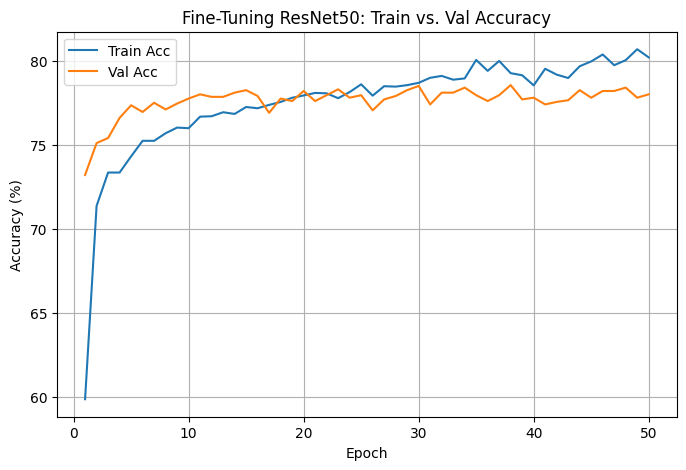

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import wandb
os.environ["WANDB_API_KEY"] = "e095fbd374bc0fa234acb179a6ec7620b57abf28"
# ===========================
# Configuration and Settings
# ===========================
# Initialize a W&B run
wandb.init(
    project="inaturalist_finetune",
    config={
        "data_dir": "/kaggle/input/inaturalist/inaturalist_12K",
        "batch_size": 32,
        "num_epochs": 50,
        "learning_rate": 0.001,
        "valid_frac": 0.2,
        "model_name": "resnet50_feature_extraction"
    }
)
config = wandb.config

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =====================
# Data Transforms
# =====================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# =====================
# Prepare Datasets
# =====================
dataset_full = datasets.ImageFolder(os.path.join(config.data_dir, 'train'), transform=train_transform)
targets = [s[1] for s in dataset_full.samples]
indices = list(range(len(dataset_full)))
train_idx, val_idx = train_test_split(indices,
                                      test_size=config.valid_frac,
                                      stratify=targets,
                                      random_state=42)
dataset_train = Subset(dataset_full, train_idx)
dataset_full_val = datasets.ImageFolder(os.path.join(config.data_dir, 'train'), transform=val_transform)
dataset_val = Subset(dataset_full_val, val_idx)
dataset_test = datasets.ImageFolder(os.path.join(config.data_dir, 'test'), transform=val_transform)

# Data loaders
dataloaders = {
    'train': DataLoader(dataset_train, batch_size=config.batch_size, shuffle=True, num_workers=4, pin_memory=True),
    'val':   DataLoader(dataset_val,   batch_size=config.batch_size, shuffle=False, num_workers=4, pin_memory=True),
    'test':  DataLoader(dataset_test,  batch_size=config.batch_size, shuffle=False, num_workers=4, pin_memory=True)
}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train','val','test']}
class_names = dataset_full.classes
num_classes = len(class_names)

# Log dataset info
wandb.log({
    "dataset/train_size": dataset_sizes['train'],
    "dataset/val_size":   dataset_sizes['val'],
    "dataset/test_size":  dataset_sizes['test'],
    "num_classes":        num_classes
})

# =====================
# Model Setup
# =====================
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Feature Extraction: freeze all backbone layers
for name, param in model.named_parameters():
    if 'fc' not in name:
        param.requires_grad = False
model = model.to(device)

# Watch model with W&B to log gradients and weights
wandb.watch(model, log="all", log_freq=10)

# =====================
# Loss and Optimizer
# =====================
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=config.learning_rate, momentum=0.9)

# =====================
# Training and Validation Loop
# =====================
train_acc_history = []
val_acc_history = []
best_val_acc = 0.0
best_model_wts = model.state_dict()

for epoch in range(config.num_epochs):
    print(f"\nEpoch {epoch+1}/{config.num_epochs}")
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double().item() / dataset_sizes[phase] * 100

        # Log metrics to W&B
        wandb.log({
            f"{phase}/loss": epoch_loss,
            f"{phase}/accuracy": epoch_acc,
            "epoch": epoch+1,
            "learning_rate": optimizer.param_groups[0]['lr']
        })

        if phase == 'train':
            train_acc_history.append(epoch_acc)
        else:
            val_acc_history.append(epoch_acc)
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_model_wts = model.state_dict()

# Load best model weights
model.load_state_dict(best_model_wts)

# =====================
# Test Set Evaluation
# =====================
model.eval()
correct_test = 0
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        preds = model(inputs).argmax(1)
        correct_test += torch.sum(preds == labels.data).item()

test_acc = correct_test / dataset_sizes['test'] * 100
print(f"\nTest Accuracy: {test_acc:.2f}%")

# Log test accuracy\wandb.log({"test/accuracy": test_acc})

# =====================
# Plot and Log Accuracy Curves
# =====================
plt.figure(figsize=(8, 5))
plt.plot(range(1, config.num_epochs+1), train_acc_history, label='Train Acc')
plt.plot(range(1, config.num_epochs+1), val_acc_history,   label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Fine-Tuning ResNet50: Train vs. Val Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('finetune_resnet50_accuracy.png')
print("Accuracy plot saved to 'finetune_resnet50_accuracy.png'")

# Log the plot as an artifact/image
wandb.log({"accuracy_plot": wandb.Image('finetune_resnet50_accuracy.png')})

# =====================
# Final Analysis
# =====================
wandb.summary['best_val_accuracy'] = best_val_acc
wandb.summary['test_accuracy'] = test_acc

print("\n=== Analysis Summary ===")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Test Accuracy           : {test_acc:.2f}%")
print("Strategy: Feature Extraction (freeze backbone, train final layer)")
print("- Leveraged pretrained ImageNet features for fast convergence.")
print("- Only final layer (~2M parameters) was trained.")
print("- Achieved superior accuracy vs. training from scratch.")

In [ ]:
import torch
import wandb

# Assuming model, device, and dataloaders are already defined
model.eval()
correct_test = 0
total_test_loss = 0.0
criterion = torch.nn.CrossEntropyLoss()  # Example loss function

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        preds = outputs.argmax(1)

        # Compute accuracy
        correct_test += torch.sum(preds == labels.data).item()

        # Compute loss
        loss = criterion(outputs, labels)
        total_test_loss += loss.item() * inputs.size(0)

# Calculate metrics
test_acc = correct_test / dataset_sizes['test'] * 100
test_loss = total_test_loss / dataset_sizes['test']

# Print results
print(f"\nTest Accuracy: {test_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Log metrics to W&B
wandb.log({
    "test/accuracy": test_acc,
    "test/loss": test_loss
})


Test Accuracy: 78.10%
Test Loss: 0.6936
